In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
%matplotlib inline

<H1><center>  <u>WHO Patient Data</u> </H1>
    
Heart disease accounts for roughly 600,000 deaths each year in the US alone, around 1 in 4 deaths. Similar trends are observed for several other regions. While it is deadly, its risks can be minimised by adopting healthier lifestyle habits with some changes having a larger impact. 

We are given a dataset provided by the World Health Organisation (WHO) containing 15 features which may or may not have impact on the occurance of heart disease. the dataset contains over 4,000 patient data. Our job is to develop a classifier that can predict whether such individuals are <i>at risk</i> within the next ten years given their respective lifestyle choices.

In this context, we will use a Logistic regression and K-NN classifier to predict whether individuals are at risk[<font color='red'>1</font>] or not at risk[<font color='red'>0</font>] using the features provided in the dataset. 

    


### <center><u>Features</u></center>

For compactness, we will denote each feature as $X_i $, where $i = 1,2,...15$. Also consider that Nomial features in this case are binomial, with 1 representing yes to the question.<br>
<ol>
    <li>Sex (Nomial): Male or female</li>
    <li>Age (Continuous)</li>
    <li>Current Smoker (Normial):  Does the patient smoke regularly?</li>
    <li>CigsPerDay (Continuous)</li>
    <li>BP meds (Nomial): If patient was on blood pressure medication</li>
    <li> prevalent Stroke (Nomial): Has the patient have a stroke previously? </li>
    <li> Prevalent Hyp (Nomial): has the patient been hyptensive in the past?</li>
    <li> Diabetes (Nomial): Does the patient have diabetes?</li>
    <li> Tot Chol: total cholesterol level (Continuous)</li>
    <li> Sys BP: systolic blood pressure (Continuous)</li>
    <li> Dia BP: diastolic blood pressure (Continuous)</li>
    <li> BMI: Body Mass Index (Continuous) </li>
    <li> Heart rate (Continuous) </li>
    <li> Glucose (Continuous): Glucose levels</li> 
    </ol>
    
For labels we use the notation $Y^j $ where $j$ represents a certain patient 

    

In [4]:
df = pd.read_csv("D:\\Datasets\\Logistic\\framingham.csv")
df.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [5]:
print("Number of patient data provided: {}".format(len(df)))

Number of patient data provided: 4238


## Data preprocessing and cleaning 

### Imputation

It's important that we first know how to handle the missing datasets. In most cases only a small fraction of data is missing from certain features. various methods of statistical imputation exist but considering the size of our dataset and the respective elements missing in our features, the most simple method is replacing the empty values with appropiate mean values. Methods of data processing is broad but there are general guidelines.

Looking at the percentage of items missing below, we can see that the fraction of missing values is most prevalent in the glucose section at 9%. Given the dataset size of ~4000, this is not too determinental to our analysis.

In [6]:
Nan_values = (pd.DataFrame(pd.isnull(df).sum(axis=0)))
((Nan_values[0])*100)/len(df)

male               0.000000
age                0.000000
education          2.477584
currentSmoker      0.000000
cigsPerDay         0.684285
BPMeds             1.250590
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179802
sysBP              0.000000
diaBP              0.000000
BMI                0.448325
heartRate          0.023596
glucose            9.155262
TenYearCHD         0.000000
Name: 0, dtype: float64

In [7]:
"""
Filling each Na value by the mean of the filters. We can observe the distribution using Seaborn. 
"""
col_names = df.columns
for name in col_names:
    temp_mean = (df[name].dropna()).mean()
    df[name] = df[name].fillna(temp_mean)

lets analyse the data. I will use the package <b>pandas profilling</b> to display a summary of my dataset

In [8]:
import pandas_profiling as pp
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Distribution of smokers by age')

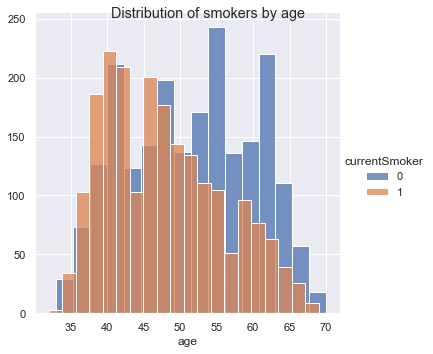

In [9]:
sns.set_theme()
age_smoker = sns.FacetGrid(df, height=5, aspect=1,hue="currentSmoker")
age_smoker.map(sns.histplot,"age")
age_smoker.add_legend()
age_smoker.fig.suptitle('Distribution of smokers by age')



Text(0.5, 0.98, 'Previous Stroke occurences - Age distribution')

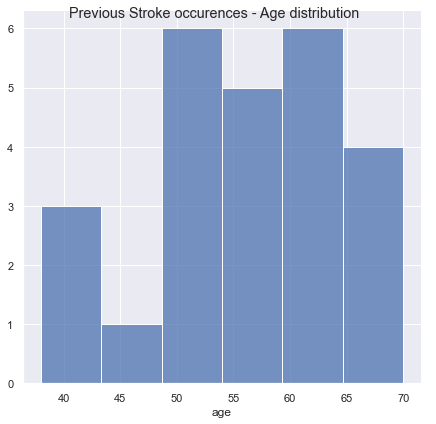

In [12]:
age_smoker = sns.FacetGrid(df[ df['prevalentStroke'] ==1] , height=6, aspect=1)
age_smoker.map(sns.histplot,"age")
age_smoker.add_legend()
age_smoker.fig.suptitle('Previous Stroke occurences - Age distribution') 


### Logistic Regression Implementation

 
Our hypothesis, $ h_\theta $(x) underlies the relationship between all features, $X_i$ and parameters. We will denote our parameters as $\beta_i$ where $i$ varies from $0$ to $15$. Within our hypothesis space, the full form of $ h_\theta $(x) is given by: <br>
<center> $ Y^j = F(\beta_0 + \sum \limits_{i=1}^{15} \sum \limits_{j=0}^{4237} \beta_i * X_i^j) $ </center> <br>
Where $F(x)$ is given as <br>
<center> $$ \frac {1}{1 + e^{-x}} $$</center> <br>
Optimal parameters are then derived using calculus. In this example, we use the gradient descent method.
<hr>
<br>

### Train/Test split  
Before undergoing training, it is crucial to split our dataset as well as normalise or scale our data. This is done mainly for two reasons: <br>
<li> Splitting our dataset allows our model to be trained and validated using a large fraction of our dataset. Given our final parameters, can our model <font color='red'> generalise </font> well to our final testing set. splitting our dataset allows us to analyse how well our model has established a good bias/variance trade off </li> <br>
<li> scaling our data allows training to be faster: Updates of our parameters are decided using multiple iterations through calculus. Having very large scale ranges may hinder training effectiveness.</li>

In [38]:
"""
Below:

We denote labels as Y with the input data as X. Using Sklearn we split our dataset in a 
random manner with a ratio of  70-30 for training/testing respectively. 

Finally, We import a Scaler from Sklearn inorder to normalise data. 

"""

X = df.iloc[:, 0:-1].values 
y = df.iloc[:,15].values

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=1337)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Import Logistic regression model and train the model by initializing random parameters first. 

In [110]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score
matrix=confusion_matrix(y_test,y_pred)

In [112]:
print("Percentage accuracy using test set: {:.2f}%"
      .format(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100))

Percentage accuracy using test set: 85.85%


Is Accuracy a reasonable metric? If however our our model always predicted that patients were at risk of getting heart disease AND 99% of our patients were shown to be at risk....then our model would have 99% accuracy. To address such issues we use Precision + Recall Metrics.<br>

We define precision as:
<center> $$ \frac {TP}{TP + FP} $$ <br> </center>
and Recall as <br>
<center> $$ \frac {TP}{TP + FN} $$ <br></center> <br>
Define:
<li>TP - True positive</li>
<li>FN - False negative</li>
<li>FP - False positive</li>

We use Precion and Recall to calculate our 'F-1' score, defined as: <br>
<center> $$ 2 *  \frac{Precision * Recall}{Precision + Recall} $$. </center>

As roughly 90% of our patients are not at risk of having a heart disease within 10 years. We can use Precision as a metric. Eseentially a value close to 1 is the optimum result. 

In [116]:
print(matrix)
#true label Y axis 
#Pred label X axis 

[[1075    6]
 [ 174   17]]


In [137]:
tn, fp, fn, tp = matrix.ravel()

print ("Precision Score: {:.2f}".format(tn/(tn + fn)))

Precision Score: 0.86
